In [144]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from itertools import combinations
import time
import sys

original_stdout = sys.stdout

# All functions are defined here. Execution in following codeblocks

def readInputMatrix(filename: str):
    matrix = []
    file = open(filename, 'r').readlines()

    for row in file:
        data = list(map(int, row.strip().split(",")))
        matrix.append(data)

    return matrix


def writeOutputMatrix(filename: str, matrix):
    file = open(filename, 'w')

    for data in matrix:
        row = ",".join(list(map(str,list(data))))
        file.write(f"{row}\n")

    return matrix

def get_input_adjacency_matrix(filename):
    matrix = readInputMatrix(filename)
    return np.array(matrix)



# TRANSFORMATION

def transform_graph_to_cost_matrices(A):
    """
    Transforms the adjacency matrix A into:
    - d_ij: distance matrix where real edges = 1, non-edges = 2
    - r_ij: resource matrix where all pairs should have 2 vertex disjoint paths
    Diagonal entries are set to 0.
    """
    # Using vectorized NumPy operations for efficiency
    d_ij = np.where(A == 1, 1, 2).astype(float)
    np.fill_diagonal(d_ij, 0)
    n = A.shape[0]
    r_ij = 2 * np.ones((n,n)).astype(float)
    np.fill_diagonal(r_ij, 0)

    return d_ij, r_ij

# Plotting Functions

def plot_weighted_graph(matrix, title):
    G = nx.Graph()
    n = matrix.shape[0]

    for i in range(n):
        for j in range(i + 1, n):  # upper triangle only to avoid duplicate edges
            G.add_edge(i, j, weight=matrix[i, j])

    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_adjacency_graph(A):
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True)
    plt.title("Original Graph from Adjacency Matrix")
    plt.tight_layout()
    plt.show()


# Brute force for Rudrata Cycle

def hamiltonian_cycle_brute_force(graph):
    def dfs(pos):
        if len(path) == n:
            if graph[path[-1]][path[0]] == 1:
                return True
            else:
                failed_cycles.append(path.copy() + [path[0]])
                return False
        dead_end = True
        for v in range(n):
            if graph[pos][v] == 1 and not visited[v]:
                dead_end = False
                visited[v] = True
                path.append(v)
                if dfs(v):
                    return True
                # Backtracking
                path.pop()
                visited[v] = False
        if dead_end:
            partial_failures.append(path.copy())  # Recording dead-end path
        return False

    n = len(graph)
    path = [0]
    visited = [False] * n
    visited[0] = True
    failed_cycles = []
    partial_failures = []

    if dfs(0):
        return path + [0]
    else:
        print("Failed Full-Length Attempts (no closing edge):")
        for p in failed_cycles:
            print(p)
        print("\nPartial Dead-End Paths:")
        for p in partial_failures:
            print(p)
        with open('rudrata_fails.txt', 'w') as f:
          sys.stdout = f
          print("Failed Full-Length Attempts (no closing edge):")
          for p in failed_cycles:
            print(p)
          print("\nPartial Dead-End Paths:")
          for p in partial_failures:
            print(p)
          sys.stdout = original_stdout
        return None


# Highlighting the Rudrata cycle.

def plot_cycle(graph, cycle):
    G = nx.from_numpy_array(graph)
    pos = nx.spring_layout(G, seed=42)

    # Drawing full graph
    nx.draw(G, pos, with_labels=True)

    if isinstance(cycle, list):
        # Preparing cycle edges
        cycle_edges = [(cycle[i], cycle[i + 1]) for i in range(len(cycle) - 1)]

        # Drawing Hamiltonian cycle in red
        nx.draw_networkx_edges(G, pos, edgelist=cycle_edges, edge_color='red', width=3)

    plt.title("Hamiltonian Cycle" if isinstance(cycle, list) else "No Hamiltonian Cycle Found")
    plt.tight_layout()
    plt.show()


# Solution Transformation

def transform_solution(A):
  return A # solution remains the exact same!



# Brute force for Reliable Network

def reliable_network_brute_force(n, d, r, b, max_time=60):
    start_time = time.time()
    edges = [(i, j, int(d[i][j])) for i in range(n) for j in range(i + 1, n)]
    # Sorting via edge weights for better pruning
    edges.sort(key=lambda x: x[2])
    best_solution = None
    failed_attempts = []
    # Checking for reliability requirements with r
    def is_valid(G):
        try:
            for u in range(n):
                for v in range(u + 1, n):
                    if r[u][v] > 0:
                        if nx.node_connectivity(G, u, v) < r[u][v]:
                            return False
            return True
        except nx.NetworkXError:
            return False

    def backtrack(i, selected, cost):
        nonlocal best_solution
        if time.time() - start_time > max_time:
            print("Could not find in time")
            with open('reliable_network_fails.txt', 'w') as f:
              sys.stdout = f
              print("Time limit exceeded.")
              sys.stdout = original_stdout
            return None
        if cost > b:
            return
        if best_solution:
            return
        if i == len(edges):
            G = nx.Graph()
            G.add_nodes_from(range(n))
            G.add_weighted_edges_from(selected)
            if is_valid(G):
                best_solution = G
            else:
                failed_attempts.append((cost, selected))
            return

        u, v, w = edges[i]

        # Including edge
        backtrack(i + 1, selected + [(u, v, w)], cost + w)
        # Excluding edge
        backtrack(i + 1, selected, cost)

    backtrack(0, [], 0)

    if not best_solution:
        print("No valid solution found. Failed configurations:")
        for cost, selected in failed_attempts:
            print(f"Cost = {cost}, Configuration = {selected}")
        with open('reliable_network_fails.txt', 'w') as f:
          sys.stdout = f
          for cost, selected in failed_attempts:
            print(f"Cost = {cost}, Configuration = {selected}")
          sys.stdout = original_stdout

    return best_solution



Distance matrix (d_ij):
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 2. 2.]
 [1. 1. 0. 1. 2.]
 [1. 2. 1. 0. 2.]
 [1. 2. 2. 2. 0.]]

Resource matrix (r_ij):
 [[0. 2. 2. 2. 2.]
 [2. 0. 2. 2. 2.]
 [2. 2. 0. 2. 2.]
 [2. 2. 2. 0. 2.]
 [2. 2. 2. 2. 0.]]

Budget: 5


<ipython-input-144-f1cbe25046b6>:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


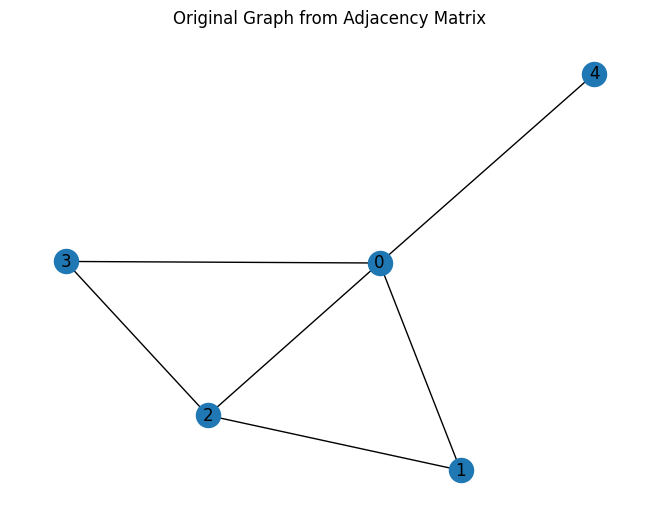

<ipython-input-144-f1cbe25046b6>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


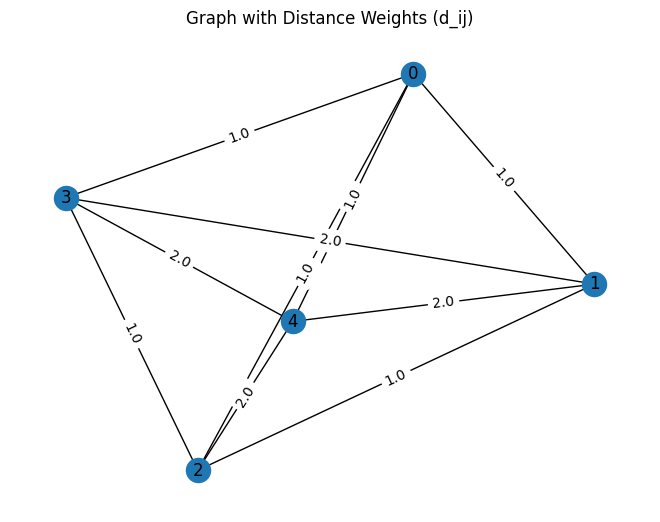

In [145]:
# INPUT
# Add file to directory and enter name here
file_name = "ip_NO_sample.txt"
A_ij = get_input_adjacency_matrix(file_name)

# TRANSFORMATION
d_ij, r_ij = transform_graph_to_cost_matrices(A_ij)
budget = len(A_ij[0])

# OUTPUT
print("Distance matrix (d_ij):\n", d_ij)
print("\nResource matrix (r_ij):\n", r_ij)
print("\nBudget:", budget)
with open('transformation.txt', 'w') as f:
    sys.stdout = f
    print("Distance matrix (d_ij):\n", d_ij)
    print("\nResource matrix (r_ij):\n", r_ij)
    print("\nBudget:", budget)
    sys.stdout = original_stdout
# PLOTS
plot_adjacency_graph(A_ij)
plot_weighted_graph(d_ij, "Graph with Distance Weights (d_ij)")



In [146]:
# IP_YES_SAMPLE SOLUTION TRANSFORMATION TO SHOW SOLUTION WORKS FOR ORIGINAL PROBLEM

# rel_net_sol = np.array([
#     [0, 1, 0, 0, 0],
#     [1, 0, 1, 0, 1],
#     [0, 1, 0, 1, 0],
#     [0, 0, 1, 0, 1],
#     [0, 1, 0, 1, 0]
# ])

# rudrata_cycle_sol = transform_solution(rel_net_sol)
# print(rudrata_cycle_sol)

[[0 1 0 0 0]
 [1 0 1 0 1]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [0 1 0 1 0]]


In [149]:
# BRUTE FORCE FOR RUDRATA CYCLE

N = A_ij.shape[0]
cycle = hamiltonian_cycle_brute_force(A_ij)
print("Hamiltonian Cycle:", cycle)
with open('rudrata_solution.txt', 'w') as f:
    sys.stdout = f
    print("Hamiltonian Cycle:", cycle)
    sys.stdout = original_stdout
if cycle is not None:
    plot_cycle(A_ij, cycle)
else:
    print("No Hamiltonian Cycle Found")
    with open('rudrata_solution.txt', 'w') as f:
      sys.stdout = f
      print("No Hamiltonian Cycle Found")
      sys.stdout = original_stdout

Failed Full-Length Attempts (no closing edge):

Partial Dead-End Paths:
[0, 1, 2, 3]
[0, 2, 1]
[0, 2, 3]
[0, 3, 2, 1]
[0, 4]
Hamiltonian Cycle: None
No Hamiltonian Cycle Found


In [150]:
# BRUTE FORCE FOR RELIABLE NETWORK.
# Caution: It will halt if time limit exceeds 1 minute. For example, it is not quick enough to check graphs of size 16.

G = reliable_network_brute_force(d_ij.shape[0], d_ij, r_ij, budget)
print(G)
if G is not None:
    adj_G = nx.adjacency_matrix(G).todense()
    print("Found valid graph with edges:")
    print(list(G.edges(data=True)))
    print("Adjacency matrix:")
    print(adj_G)
    with open('reliable_network_solution.txt', 'w') as f:
      sys.stdout = f
      print("Found valid graph with edges:")
      print(list(G.edges(data=True)))
      print("Adjacency matrix:")
      print(adj_G)
      sys.stdout = original_stdout
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(7, 6))
    nx.draw(G, pos, with_labels=True)
    plt.title("Original Graph from Adjacency Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("No valid reliable network found.")
    with open('reliable_network_solution.txt', 'w') as f:
      sys.stdout = f
      print("No valid reliable network found.")
      sys.stdout = original_stdout


No valid solution found. Failed configurations:
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1), (1, 2, 1)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1), (2, 3, 1)]
Cost = 4, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (1, 2, 1), (2, 3, 1)]
Cost = 4, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (1, 2, 1)]
Cost = 4, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (2, 3, 1)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (1, 3, 2)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (1, 4, 2)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (2, 4, 2)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (3, 4, 2)]
Cost = 3, Configuration = [(0, 1, 1), (0, 2, 1), (0, 3, 1)]
Cost = 5, Configuration = [(0, 1, 1), (0, 2, 1), (0, 4, 1), (1, 2, 1), (2, 3, 1)]
Cost = 4, Configuration = [(0, 1, 1), (0, 2, 1), (0, 4, 1), (1, 2, 